In [1]:
import numpy as np
#import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [97]:
def compute_params(params):
    stats_pt_max = params['stats_pt_max']
    stats_pt_per_phase = params['stats_pt_per_phase']
    n_phases_per_evo = params['n_phases_per_evo']
    stats_pt_per_evo = params['stats_pt_per_evo']
    #n_pets = params['n_pets']
    lvl_per_phase = params['lvl_per_phase']
    lvl_per_evo = params['lvl_per_evo']
    print(params)
    
    print('STATS pt per evolotion loop: %d'%(stats_pt_per_phase*n_phases_per_evo+stats_pt_per_evo))
    n_evos = stats_pt_max/(stats_pt_per_phase*n_phases_per_evo+stats_pt_per_evo)
    print('# evolutions before rounding: '+str(n_evos))
    n_evos = int(n_evos)
    stats_pt_max = n_evos*(stats_pt_per_phase*n_phases_per_evo+stats_pt_per_evo)
    n_phases = n_evos*n_phases_per_evo
    n_lvl = n_evos*lvl_per_evo + n_evos*n_phases_per_evo*lvl_per_phase
    print('# evolutions after rounding: %d\n# phases: %d\n# levels: %d\n# STATS pt: %d'%(n_evos, n_phases, n_lvl, stats_pt_max))
    
    params['stats_pt_max'] = stats_pt_max
    params['n_evos'] = n_evos
    params['n_phases'] = n_phases
    params['n_lvl'] = n_lvl
    return params

In [39]:
def compute_turning_points(params,  
    periods=np.array([2,3.5,5,7,7.5]), #by weeks, ~xp
    n_evos_per_period=np.array([5,5,5,5,5]), #sum up to n_evos, ~lvl
    xp_scaler = 10000):
    
    stats_pt_max = params['stats_pt_max']
    stats_pt_per_phase = params['stats_pt_per_phase']
    n_phases_per_evo = params['n_phases_per_evo']
    stats_pt_per_evo = params['stats_pt_per_evo']
    #n_pets = params['n_pets']
    lvl_per_phase = params['lvl_per_phase']
    lvl_per_evo = params['lvl_per_evo']
    
    #n_evos, n_phases, n_lvl = compute_params(params)
    #n_weeks = sum(periods)
    
    xp_per_period = periods * xp_scaler
    lvl_per_period = n_evos_per_period*(lvl_per_evo + n_phases_per_evo*lvl_per_phase)
    
    period_ax = [sum(periods[0:i]) for i in range(0, len(periods)+1)]
    xp_ax = [sum(xp_per_period[0:i]) for i in range(0, len(xp_per_period)+1)]
    lvl_ax = [sum(lvl_per_period[0:i]) for i in range(0, len(lvl_per_period)+1)]
    
    turning_points = [lvl_ax, xp_ax]
    
    for i in range(1,len(xp_ax)):
        print('%s-%s weeks: lvl %d\t%d xp'%(str(period_ax[i-1]), str(period_ax[i]), lvl_ax[i], xp_ax[i]))
        
    return turning_points


In [83]:
def plot_func(f):
    plt.figure(figsize=(12,8))
    for p,v in f.items():
        x = np.array([i for i in range(p[0],p[1]+1)])
        k = v[1]
        c = v[2]
        if v[0] == 1:
            y = k*x + c
        if v[0] == 2:
            y = k*x**2 + c
        if v[0] == 3:
            y = k*x**3 + c
        plt.plot(x,y)
    plt.xlabel('Level')
    plt.ylabel('XP')
    plt.show()

In [88]:
def fit_func(turning_points, 
             func_per_period=[3,2,2,2,1], 
             plot=True):
    
    lvl_xp_func = {}
    
    for i in range(len(turning_points[0])-1):
        y = np.array([turning_points[1][i], turning_points[1][i+1]]) #y

        if func_per_period[i] == 1: #y = k * x + c
            x = np.array([[turning_points[0][i], 1],[turning_points[0][i+1],1]])
        if func_per_period[i] == 2: #y = k * x^2 + c
            x = np.array([[turning_points[0][i]**2, 1],[turning_points[0][i+1]**2,1]])
        if func_per_period[i] == 3: #y = k * x^3 + c
            x = np.array([[turning_points[0][i]**3, 1],[turning_points[0][i+1]**3,1]])
        
        res = np.linalg.solve(x, y)
        k = res[0]
        c = res[1]
        
        lvl_xp_func[(turning_points[0][i], turning_points[0][i+1])] = [func_per_period[i], k, c]
    
    print(lvl_xp_func)
    
    #lvl_max = turning_points[0][-1]
    
    lvl_xp_lookup = {}
    for p,v in lvl_xp_func.items():
        x = np.array([i for i in range(p[0],p[1]+1)])
        k = v[1]
        c = v[2]
        if v[0] == 1:
            y = k*x + c
        if v[0] == 2:
            y = k*x**2 + c
        if v[0] == 3:
            y = k*x**3 + c
        for i in range(len(x)):
            if x[i] not in lvl_xp_lookup.keys():
                lvl_xp_lookup[x[i]] = y[i]
        
        
    if plot:
        plot_func(lvl_xp_func)
    
    #print(lvl_xp_lookup)

    return lvl_xp_func, lvl_xp_lookup
    

In [108]:
def map_xp_lvl(params,  
               periods=np.array([2,3.5,5,7,7.5]), #sum up to n_weeks
               n_evos_per_period=np.array([5,5,5,5,5]), #sum up to n_evos
               func_per_period=[3,2,2,2,1], #1: linear, 2: quadratic, 3: cubic
               xp_scaler = 10000):
    
    params = compute_params(params)
    params['periods'] = periods
    params['n_evos_per_period'] = n_evos_per_period
    params['xp_scaler'] = xp_scaler
    
    turning_points = compute_turning_points(params, periods, n_evos_per_period, xp_scaler)
    lvl_xp_func, lvl_xp_lookup = fit_func(turning_points, func_per_period, plot=True)
    
    #if sum(periods) != n_weeks:
    #    print('Warning: sum of periods doesn''t match n_weeks.\nsum of periods: %d    n_weeks: %d'%(int(sum(periods)), n_weeks)
    
    return params, lvl_xp_func, lvl_xp_lookup
    

# Model 1

In [99]:
params1 = {
    'stats_pt_max':1000,
    'stats_pt_per_phase':4,
    'n_phases_per_evo':5,
    'stats_pt_per_evo':20,
    #'n_pets':1,
    #'n_weeks':25,
    'lvl_per_phase':1, #int, >=1
    'lvl_per_evo':1 #int, >=1
}

In [100]:
params1 = compute_params(params1)

{'stats_pt_max': 1000, 'stats_pt_per_phase': 4, 'n_phases_per_evo': 5, 'stats_pt_per_evo': 20, 'lvl_per_phase': 1, 'lvl_per_evo': 1}
STATS pt per evolotion loop: 40
# evolutions before rounding: 25.0
# evolutions after rounding: 25
# phases: 125
# levels: 150
# STATS pt: 1000


In [101]:
turning_points_1 = compute_turning_points(params1,  
    periods=np.array([2,3.5,5,7,7.5]), #by weeks, ~xp
    n_evos_per_period=np.array([5,5,5,5,5]), #sum up to # evolutions, ~lvl
    xp_scaler = 10000)

0-2.0 weeks: lvl 30	20000 xp
2.0-5.5 weeks: lvl 60	55000 xp
5.5-10.5 weeks: lvl 90	105000 xp
10.5-17.5 weeks: lvl 120	175000 xp
17.5-25.0 weeks: lvl 150	250000 xp


In [102]:
turning_points_1

[[0, 30, 60, 90, 120, 150],
 [0, 20000.0, 55000.0, 105000.0, 175000.0, 250000.0]]

{'stats_pt_max': 1000, 'stats_pt_per_phase': 4, 'n_phases_per_evo': 5, 'stats_pt_per_evo': 20, 'lvl_per_phase': 1, 'lvl_per_evo': 1, 'n_evos': 25, 'n_phases': 125, 'n_lvl': 150, 'periods': array([2. , 3.5, 5. , 7. , 7.5]), 'n_evos_per_period': array([5, 5, 5, 5, 5]), 'xp_scaler': 10000}
STATS pt per evolotion loop: 40
# evolutions before rounding: 25.0
# evolutions after rounding: 25
# phases: 125
# levels: 150
# STATS pt: 1000
0-2.0 weeks: lvl 30	20000 xp
2.0-5.5 weeks: lvl 60	55000 xp
5.5-10.5 weeks: lvl 90	105000 xp
10.5-17.5 weeks: lvl 120	175000 xp
17.5-25.0 weeks: lvl 150	250000 xp
{(0, 30): [3, 0.7407407407407407, 0.0], (30, 60): [2, 12.962962962962962, 8333.333333333334], (60, 90): [2, 11.11111111111111, 15000.000000000004], (90, 120): [2, 11.11111111111111, 15000.0], (120, 150): [1, 2500.000000000001, -125000.00000000009]}


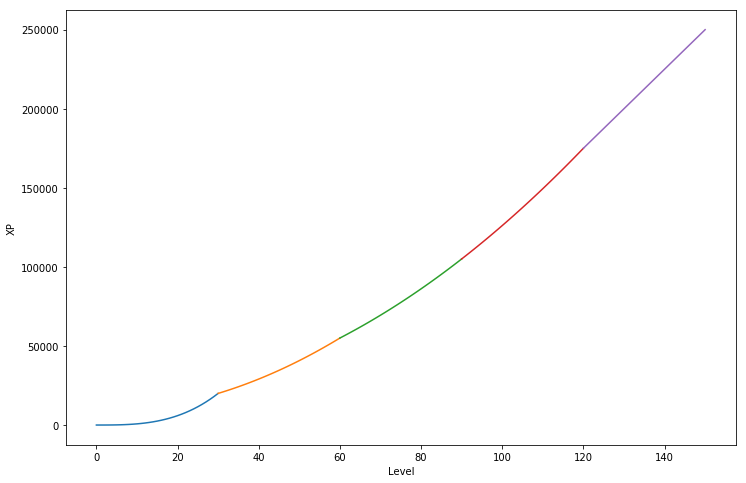

In [109]:
params1, lvl_xp_func_1, lvl_xp_lookup_1 = map_xp_lvl(params1,  
               periods=np.array([2,3.5,5,7,7.5]), #sum up to n_weeks
               n_evos_per_period=np.array([5,5,5,5,5]), #sum up to n_evos
               func_per_period=[3,2,2,2,1], #1: linear, 2: quadratic, 3: cubic
               xp_scaler = 10000)